# Whale Tail Bounding Box Detection
In this part of the project I will use PyTorch in order to construct a bounding box detector network. For this part of the project I will start by watching the Fast.ai video on object detection and localization (http://course.fast.ai/lessons/lesson8.html) and then attempt to use their notebook to construct a network that can perform bounding box detection for my labelled dataset. Once we have a network that is doing a good job of generating bounding boxes we will move on to the next step of the project which will involve labelling fluke/notch points on the whale’s tail


In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
torch.cuda.set_device(0)

import pandas as pd

## Data Exploration
Let's visually inspect our dataset and make sure that the bounding box labels we have make sense

In [3]:
PATH = Path('/home/ubuntu/data/whale-categorization-playground')
list(PATH.iterdir())

[PosixPath('/home/ubuntu/data/whale-categorization-playground/train'),
 PosixPath('/home/ubuntu/data/whale-categorization-playground/bb-train'),
 PosixPath('/home/ubuntu/data/whale-categorization-playground/tmp'),
 PosixPath('/home/ubuntu/data/whale-categorization-playground/sample_submission.csv'),
 PosixPath('/home/ubuntu/data/whale-categorization-playground/bb_kaggle.csv'),
 PosixPath('/home/ubuntu/data/whale-categorization-playground/train.csv'),
 PosixPath('/home/ubuntu/data/whale-categorization-playground/models'),
 PosixPath('/home/ubuntu/data/whale-categorization-playground/test.zip')]

In [4]:
IMG_PATH = PATH/"train"
list(IMG_PATH.iterdir())[:5]

[PosixPath('/home/ubuntu/data/whale-categorization-playground/train/beba228a.jpg'),
 PosixPath('/home/ubuntu/data/whale-categorization-playground/train/6c5ad43e.jpg'),
 PosixPath('/home/ubuntu/data/whale-categorization-playground/train/974961a4.jpg'),
 PosixPath('/home/ubuntu/data/whale-categorization-playground/train/d9f3391e.jpg'),
 PosixPath('/home/ubuntu/data/whale-categorization-playground/train/f1ca32dc.jpg')]

In [5]:
test_image = list(IMG_PATH.iterdir())[:5][0]
im = open_image(test_image)

In [6]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

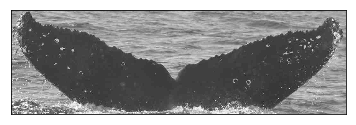

In [7]:
show_img(im)

In [8]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])
    
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)
    
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)
    
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

## Extract Bounding Boxes
We are using a file names bb_kaggle.csv in order to fetch our bounding box labels. Let's try to load this data.

In [9]:
bb_df = pd.read_csv(PATH/"bb_kaggle.csv")

In [10]:
bb_df.head(2)

,fn,bbox
0,097f138b.jpg,20 3 423 1042
1,c85f1d58.jpg,14 25 547 1009


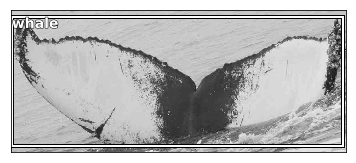

In [11]:
im = open_image(PATH/"train"/bb_df.head(1).iloc[0]['fn'])
ax = show_img(im)
b = bb_hw([20, 3, 423, 1042])
draw_rect(ax, b)
draw_text(ax, b[:2], 'whale')

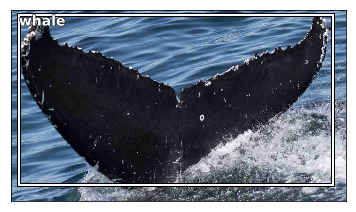

In [12]:
im = open_image(PATH/"train"/bb_df.head(2).iloc[1]['fn'])
ax = show_img(im)
b = bb_hw([14, 25, 547, 1009])
draw_rect(ax, b)
draw_text(ax, b[:2], 'whale')

## Build our model
Now that we feel relativley confident that the labels we have in our file are correct we can move on to building our model. We will base our model off of Resnet34 and modify the final layer of the network to add 4 activations which correspond to our x,y,w,h of our bounding box.

In [13]:
BB_CSV = PATH/'bb_kaggle.csv'
JPEGS = 'bb-train'

In [14]:
BB_CSV.open().readlines()[:5]

['fn,bbox\n',
 '097f138b.jpg,20 3 423 1042\n',
 'c85f1d58.jpg,14 25 547 1009\n',
 '0739fcdc.jpg,48 37 304 1020\n',
 '12440f36.jpg,75 34 516 1019\n']

### Define our model

In [69]:
f_model=resnet34
sz=224
bs=64

Set `continuous=True` to tell fastai this is a regression problem, which means it won't one-hot encode the labels, and will use MSE as the default crit.

Note that we have to tell the transforms constructor that our labels are coordinates, so that it can handle the transforms correctly.

Also, we use CropType.NO because we want to 'squish' the rectangular images into squares, rather than center cropping, so that we don't accidentally crop out some of the objects. (This is less of an issue in something like imagenet, where there is a single object to classify, and it's generally large and centrally located).

In [70]:
augs = [RandomFlip(tfm_y=TfmType.COORD),
        RandomRotate(10, tfm_y=TfmType.COORD),
        RandomLighting(0.05,0.05, tfm_y=TfmType.COORD)]

In [196]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=augs)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms, continuous=True, bs=16)

[  8.  21. 207. 159.]
[  9.  11. 208. 179.]
[  7.   0. 210. 217.]
[ 10.  21. 206. 159.]
[  8.   0. 210. 209.]
[  5.   0. 212. 223.]
[  8.  17. 207. 167.]
[  8.  16. 207. 169.]
[  7.   0. 211. 221.]


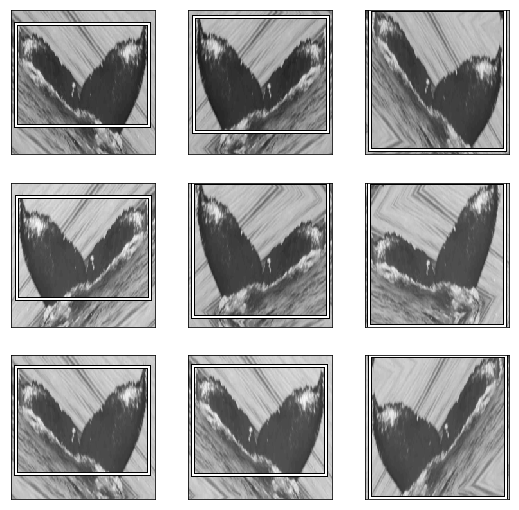

In [173]:
idx=3
fig,axes = plt.subplots(3,3, figsize=(9,9))
for i,ax in enumerate(axes.flat):
    x,y=next(iter(md.aug_dl))
    ima=md.val_ds.denorm(to_np(x))[idx]
    b = bb_hw(to_np(y[idx]))
    print(b)
    show_img(ima, ax=ax)
    draw_rect(ax, b)

In [73]:
head_reg4 = nn.Sequential(Flatten(), nn.Linear(25088,4))
learn = ConvLearner.pretrained(f_model, md, custom_head=head_reg4)
learn.opt_fn = optim.Adam
learn.crit = nn.MSELoss()

In [74]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 56, 

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 59%|█████▉    | 20/34 [00:02<00:01,  9.68it/s, loss=6.56e+04]


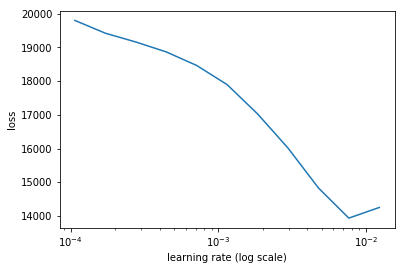

In [75]:
learn.lr_find(1e-5,100)
learn.sched.plot(5)

In [76]:
lr = 1e-2

In [77]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                                
    0      8377.527105 1845.716114
    1      4050.908278 376.688273                             
    2      1923.900481 253.917318                             



[array([253.91732])]

In [78]:
lrs = np.array([lr/100,lr/10,lr])

In [79]:
learn.freeze_to(-2)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 62%|██████▏   | 21/34 [00:02<00:01,  9.15it/s, loss=3.1e+03] 


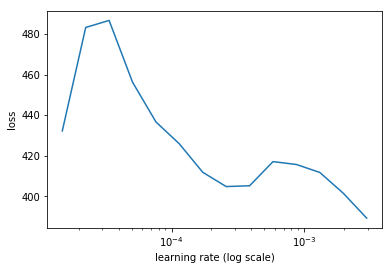

In [80]:
lrf=learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [81]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                                
    0      1320.105398 704.683967
    1      767.058413 241.748143                              
    2      465.891748 163.677893                         



[array([163.67789])]

In [82]:
learn.freeze_to(-3)

In [86]:
learn.fit(lrs, 2, cycle_len=3)

HBox(children=(IntProgress(value=0, description='Epoch', max=6), HTML(value='')))

epoch      trn_loss   val_loss                           
    0      721.99945  563.229455
    1      440.616712 8215.074116                        
    2      298.193316 137.679631                         
    3      347.750344 624.964048                         
    4      296.000277 396.081527                         
    5      219.025538 109.624608                         



[array([109.62461])]

In [175]:
x,y = next(iter(md.val_dl))
learn.model.eval()
preds = to_np(learn.model(VV(x)))
print(preds)

torch.Size([16, 3, 224, 224])
[[  5.84886   7.29995 179.96268 219.26768]
 [ 74.60179  46.7234  135.10318 182.61296]
 [  6.27024   7.05715 191.09607 215.6617 ]
 [ -0.20952  13.14784 181.52882 213.63348]
 [ 16.51653  -0.28362 107.4342  219.2232 ]
 [ 44.19333  23.24437 158.91771 197.55553]
 [  1.36252   0.01966 195.22058 222.46155]
 [ 15.66033  21.45692 203.44888 198.06078]
 [ 43.64646   7.14435 133.9707  215.81218]
 [ 61.3348    7.00185 133.34065 208.5395 ]
 [ 71.74107  23.82548 148.88457 201.85753]
 [ 62.03893  11.97857 156.97568 216.32921]
 [  5.06463   2.33643 206.19345 218.31802]
 [ 43.42596   3.46124 177.3548  222.94704]
 [ 34.0907    0.84496 180.25447 221.60205]
 [ 64.07594  18.46127 153.13075 199.48145]]


In [89]:
learn.save('reg4')

In [132]:
learn.load('reg4')

(224, 224, 3)
(224, 224, 3)


IndexError: index 1 is out of bounds for axis 0 with size 1

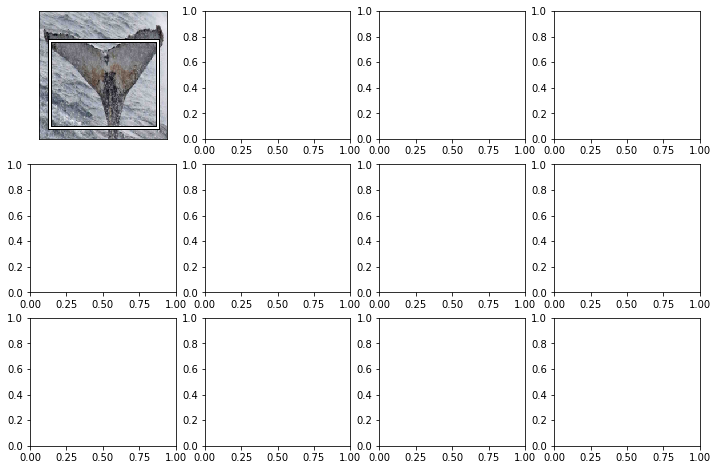

In [214]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))

for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(to_np(x))[i]
    b = bb_hw(preds[i])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
plt.tight_layout()

# Apply model to images
Let's build a new training set using our constructed model that crops all of our existing test images and places the new results in a cropped-train directory.

In [228]:
train_images = list(IMG_PATH.iterdir())
train_images[:4]

[PosixPath('/home/ubuntu/data/whale-categorization-playground/train/beba228a.jpg'),
 PosixPath('/home/ubuntu/data/whale-categorization-playground/train/6c5ad43e.jpg'),
 PosixPath('/home/ubuntu/data/whale-categorization-playground/train/974961a4.jpg'),
 PosixPath('/home/ubuntu/data/whale-categorization-playground/train/d9f3391e.jpg')]

(600, 1050, 3)


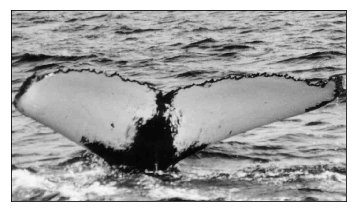

In [272]:
i = train_images[2]
im = open_image(i)
print(im.shape)
show_img(im)

In [273]:
trn_tfms, val_tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO)
im = val_tfms(open_image(i))
preds = learn.predict_array(im[None])

In [274]:
preds

array([[ 43.65857,   4.78987, 183.91342, 216.1717 ]], dtype=float32)

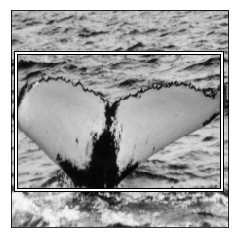

In [275]:
ima=md.val_ds.denorm(to_np(im[None]))[0]
ax = show_img(ima)
b = bb_hw(preds[0])
draw_rect(ax, b)

# TODO: Apply model to all images in folder to create modified training set